In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/dtataset_5.zip -d /content/retinopathy

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory( directory ="/content/retinopathy/train"#training dataset directory
,target_size =(224 ,224) )
tsdata = ImageDataGenerator()
testdata = tsdata.flow_from_directory( directory ="/content/retinopathy/val"#validation dataset directory
                                      , target_size =(224 ,224) )

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
# Load pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Add classification layers on top of base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.1),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    Dense(5, activation='softmax')
])

# Compile model
model.compile(tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=1e-9), loss='categorical_crossentropy', metrics=['accuracy','Precision','FalseNegatives','FalsePositives','TrueNegatives','TruePositives'])
#model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
# Define callbacks
from keras.callbacks import ModelCheckpoint
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, verbose=1, mode='max', restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, mode='max', min_lr=0.0000001)
#reduce_lr=ReduceLROnPlateau(monitor="val_accuracy",mode="max",factor=0.8,patience=5,verbose=1,min_delta=0.0000001)
checkpoint = ModelCheckpoint("dens.h5", monitor ='val_accuracy',
verbose =1, save_best_only =True , save_weights_only =False , mode ='auto',period =1)
# Train model
history = model.fit(
    traindata,
    epochs=50,
    validation_data=testdata,
    callbacks=[earlystop, lr_scheduler,checkpoint]
)


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
92/92 [==============================] - ETA: 0s - loss: 1.2369 - accuracy: 0.5664 - precision: 0.6638 - false_negatives: 1476.0000 - false_positives: 736.0000 - true_negatives: 10980.0000 - true_positives: 1453.0000
Epoch 1: val_accuracy improved from -inf to 0.42033, saving model to dens.h5
92/92 [==============================] - 52s 401ms/step - loss: 1.2369 - accuracy: 0.5664 - precision: 0.6638 - false_negatives: 1476.0000 - false_positives: 736.0000 - true_negatives: 10980.0000 - true_positives: 1453.0000 - val_loss: 1.4350 - val_accuracy: 0.4203 - val_precision: 1.0000 - val_false_negatives: 349.0000 - val_false_positives: 0.0000e+00 - val_true_negatives: 1456.0000 - val_true_positives: 15.0000 - lr: 1.0000e-04
Epoch 2/50
92/92 [==============================] - ETA: 0s - loss: 0.4990 - accuracy: 0.8173 - precision: 0.8534 - false_negatives: 618.0000 - false_positives: 397.0000 - true_negatives: 11319.0000 - true_positives: 2311.0000
Epoch 2: val_accuracy did not imp

In [ ]:
tssdata = ImageDataGenerator()
tst = tssdata.flow_from_directory( directory ="/content/retinopathy/test"
,target_size =(224 ,224) )

Found 2848 images belonging to 5 classes.


In [ ]:
model.evaluate(tst)

89/89 [==============================] - 9s 100ms/step - loss: 0.1678 - accuracy: 0.9705 - precision: 0.9705 - false_negatives: 84.0000 - false_positives: 84.0000 - true_negatives: 11308.0000 - true_positives: 2764.0000


[0.16777174174785614,
 0.9705055952072144,
 0.9705055952072144,
 84.0,
 84.0,
 11308.0,
 2764.0]

In [ ]:
import tqdm
#tst.reset()
X_test, Y_test = next(tst)
for i in tqdm.tqdm(range(int(tst.n/32))):
  img, label = next(tst)
  X_test = np.append(X_test, img, axis=0 )
  Y_test = np.append(Y_test, label, axis=0)
print(X_test.shape, Y_test.shape)

100%|██████████| 89/89 [00:40<00:00,  2.22it/s]

(2880, 224, 224, 3) (2880, 5)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report

predictions = model.predict(X_test)

y_pred = np.argmax(predictions, axis=1)

true_classes =  np.argmax(Y_test, axis=1)

#class_labels = list(tst.class_indices.keys())

#print(class_labels)

print(confusion_matrix(true_classes, y_pred))

90/90 [==============================] - 10s 92ms/step
[[840   0   0   0   0]
 [  0 688   0   0   0]
 [  0   0 460   0   0]
 [  0   0   0 323  24]
 [  0   0   0  61 484]]


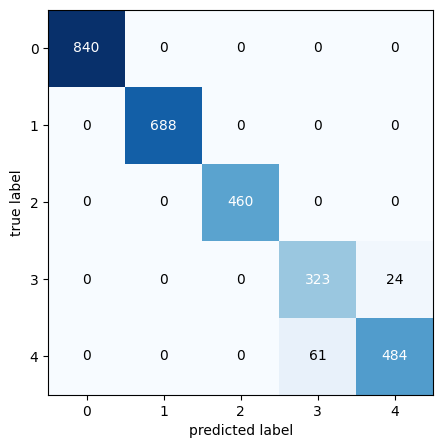

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
CM=confusion_matrix(true_classes, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=CM,figsize=(5,5))
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix



# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

def calculate_precision(cm, class_index):
    # Extract the true positives and false positives for the specified class
    tp = cm[class_index, class_index]
    fp = sum(cm[:, class_index]) - tp

    # Calculate precision
    precision = tp / (tp + fp)
    return precision

def calculate_recall(cm, class_index):
    # Extract the true positives and false negatives for the specified class
    tp = cm[class_index, class_index]
    fn = sum(cm[class_index, :]) - tp

    # Calculate recall
    recall = tp / (tp + fn)
    return recall

def calculate_f1_score(precision, recall):
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

num_classes = cm.shape[0]  # Number of classes in your multiclassification problem

# Calculate precision, recall, and F1 score for each class
precisions = []
recalls = []
f1_scores = []
for class_index in range(num_classes):
    precision = calculate_precision(cm, class_index)
    recall = calculate_recall(cm, class_index)
    f1_score = calculate_f1_score(precision, recall)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)

# Print precision, recall, and F1 score for each class
for class_index in range(num_classes):
    print(f"Metrics for class {class_index}:")
    print(f"  Precision: {precisions[class_index]}")
    print(f"  Recall: {recalls[class_index]}")
    print(f"  F1 Score: {f1_scores[class_index]}")
    print()


Metrics for class 0:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0

Metrics for class 1:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0

Metrics for class 2:
  Precision: 1.0
  Recall: 1.0
  F1 Score: 1.0

Metrics for class 3:
  Precision: 0.8411458333333334
  Recall: 0.930835734870317
  F1 Score: 0.8837209302325582

Metrics for class 4:
  Precision: 0.952755905511811
  Recall: 0.8880733944954129
  F1 Score: 0.919278252611586



In [ ]:
from sklearn.metrics import classification_report

# Assuming you have the true labels and predicted labels for your multiclassification model


# Generate the classification report
report = classification_report(true_labels, predicted_labels)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       840
           1       1.00      1.00      1.00       688
           2       1.00      1.00      1.00       460
           3       0.84      0.93      0.88       347
           4       0.95      0.89      0.92       545

    accuracy                           0.97      2880
   macro avg       0.96      0.96      0.96      2880
weighted avg       0.97      0.97      0.97      2880



In [ ]:
model.save("/content/Densenet-121_5_classes.h5")